Датасет **tmdb_data** содержит информацию о фильмах, собранную с платформы TMDB

- `id` - уникальный идентификатор фильма
- `title` - англоязычное название фильма
- `original_title` - оригинальное название фильма
- `original_language` - язык оригинала
- `release_date` - дата выхода фильма
- `genres` - жанры фильма
- `budget` - бюджет фильма (в долларах)
- `revenue` - кассовые сборы, доход (в долларах)
- `vote_average` - рейтинг фильма, основанный на пользовательских голосах
- `production_countries` - список стран, учавствовавших в производстве фильма

Датасет **cpi_data** содержит информацию о значении cpi на каждый месяц с 1913 года

- `cpi_date` - дата (ГГГГ-ММ-01)
- `cpi` - значение cpi

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
pd.options.display.float_format='{:.2f}'.format
pd.set_option('display.max_columns', None)

- Загружаем датасеты, оставляя необходимые столбцы 
- Преобразовываем типы данных (`year` в датасете cpi_data и `release_date` в tmdb_data)
- Переименовываем столбец `year` в датасете cpi_data на `cpi_date`

In [3]:
columns_tmdb = [
    "id",
    "title",                 
    "original_title",        
    "original_language",     
    "release_date",          
    "genres",                
    "budget",                
    "revenue",               
    "vote_average",          
    "production_countries"   
]

In [4]:
df_tmdb = pd.read_csv(
    '../data/raw/tmdb_data.csv',
    usecols=columns_tmdb,
    parse_dates=['release_date']
    )
df_cpi = pd.read_csv(
    '../data/raw/cpi_data.csv',
    parse_dates=['year']
    ).rename(columns={'year': 'cpi_date'})

In [5]:
df_cpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   cpi_date  1348 non-null   datetime64[ns]
 1   cpi       1348 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 21.2 KB


In [6]:
print(f'''Датасет df_cpi состоит из:
- {df_cpi.shape[0]} строк
- {df_cpi.shape[1]} столбцов''')

Датасет df_cpi состоит из:
- 1348 строк
- 2 столбцов


In [7]:
df_cpi.head(3)

,cpi_date,cpi
0,1913-01-01,9.80
1,1913-02-01,9.80
2,1913-03-01,9.80


- Объявляем переменную **latest_cpi**, которая будет хранить информацию о последнем зафиксированном значении cpi

In [8]:
latest_cpi = df_cpi.loc[df_cpi['cpi_date'].idxmax(), 'cpi']
print(f'Значение актуального CPI = {latest_cpi}')

Значение актуального CPI = 320.795


In [9]:
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235782 entries, 0 to 1235781
Data columns (total 10 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   id                    1235782 non-null  int64         
 1   title                 1235769 non-null  object        
 2   vote_average          1235782 non-null  float64       
 3   release_date          1005119 non-null  datetime64[ns]
 4   revenue               1235782 non-null  int64         
 5   budget                1235782 non-null  int64         
 6   original_language     1235782 non-null  object        
 7   original_title        1235769 non-null  object        
 8   genres                720985 non-null   object        
 9   production_countries  667080 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 94.3+ MB


In [10]:
print(f'''Датасет df_tmdb состоит из:
- {df_tmdb.shape[0]} строк
- {df_tmdb.shape[1]} столбцов''')

Датасет df_tmdb состоит из:
- 1235782 строк
- 10 столбцов


- Сохраняем в переменную **old_rows** данные о количестве строк в датасете с фильмами до предобработки, чтобы позже оценить количество удаленной информации

In [11]:
old_rows = df_tmdb.shape[0]
old_rows

1235782

### Смена типов данных

In [12]:
df_tmdb.dtypes

id                               int64
title                           object
vote_average                   float64
release_date            datetime64[ns]
revenue                          int64
budget                           int64
original_language               object
original_title                  object
genres                          object
production_countries            object
dtype: object

Типы данных корректны

- Преобразуем содержимое строковых данных к нижнему регистру, чтобы избежать возможных дубликатов

In [13]:
str_column = df_tmdb.select_dtypes(include='object').columns
for col in str_column:
    df_tmdb[col] = df_tmdb[col].str.lower().str.strip()
df_tmdb[str_column].head(3)

,title,original_language,original_title,genres,production_countries
0,inception,en,inception,"action, science fiction, adventure","united kingdom, united states of america"
1,interstellar,en,interstellar,"adventure, drama, science fiction","united kingdom, united states of america"
2,the dark knight,en,the dark knight,"drama, action, crime, thriller","united kingdom, united states of america"


### Объединяем датафреймы

- Объединяем df_tmdb и df_cpi по дате начала месяца. Для этого добавим новый столбец в df_tmdb, который приведет release_date к началу месяца

In [14]:
df_tmdb['release_month'] = (df_tmdb['release_date']
                            .dt.to_period('M')
                            .dt.to_timestamp()
                            )
df_tmdb['release_month'].head(2)

0   2010-07-01
1   2014-11-01
Name: release_month, dtype: datetime64[ns]

In [15]:
df_merged = df_tmdb.merge(df_cpi,
                          left_on='release_month',
                          right_on='cpi_date',
                          how='left')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235782 entries, 0 to 1235781
Data columns (total 13 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   id                    1235782 non-null  int64         
 1   title                 1235769 non-null  object        
 2   vote_average          1235782 non-null  float64       
 3   release_date          1005119 non-null  datetime64[ns]
 4   revenue               1235782 non-null  int64         
 5   budget                1235782 non-null  int64         
 6   original_language     1235782 non-null  object        
 7   original_title        1235769 non-null  object        
 8   genres                720985 non-null   object        
 9   production_countries  667080 non-null   object        
 10  release_month         1005119 non-null  datetime64[ns]
 11  cpi_date              991969 non-null   datetime64[ns]
 12  cpi                   991969 non-null   fl

### Проверка на дубликаты

In [16]:
print(f'Найдено {df_merged.duplicated().sum()} полных дубликатов строк')

Найдено 474 полных дубликатов строк


- удаляем их

In [17]:
df_merged = df_merged.drop_duplicates().reset_index(drop=True)
df_merged.duplicated().sum()

np.int64(0)

- Проверим, есть ли дубликаты по столбцам с информацией об оригинальном названии фильма и датой релиза

In [18]:
print(f'''Найдено {df_merged[['original_title', 'release_date']].duplicated().sum()} дубликатов''')

Найдено 19257 дубликатов


- Фильмы с одинаковым оригинальным названием и одинаковой датой релиза могут указывать на дубликаты - удаляем их

In [19]:
df_merged = df_merged.drop_duplicates(subset=['original_title', 'release_date'])
df_merged = df_merged.reset_index(drop=True)

Одинаковые названия фильмов действительно могут встречаться - главное, чтобы даты релизов не совпадали

- Теперь проверим дубликаты, связанные с англоязычным названием и датой релиза

In [20]:
print(f'''Найдено {df_merged[['title', 'release_date']].duplicated().sum()} дубликатов''')

Найдено 1861 дубликатов


In [21]:
df_merged[df_merged.duplicated(subset=['title', 'release_date'], keep=False)][['title', 'release_date']].value_counts()

title                 release_date
chosen 2              2020-01-13      3
fatal love            1993-01-01      3
8 seconds             1994-02-25      2
resurrection of love  1973-01-01      2
run!                  2013-10-23      2
                                     ..
gray                  2016-02-04      2
golmorich             2021-02-14      2
god's gift            1998-01-01      2
girls                 2014-07-30      2
zhanxiou village      2007-05-20      2
Name: count, Length: 345, dtype: int64

Проверим фильм  `chosen 2`, чтобы понять, стоит ли нам считать совпадение по дате релиза и англоязычному названию - дубликатами

In [22]:
df_merged[df_merged['title'] == 'chosen 2']

,id,title,vote_average,release_date,revenue,budget,original_language,original_title,genres,production_countries,release_month,cpi_date,cpi
364704,1160183,chosen 2,0.00,2020-01-13,0,0,en,杀无赦2：ⅱ同盟,NaN,NaN,2020-01-01,2020-01-01,257.97
364706,1160184,chosen 2,0.00,2020-01-13,0,0,en,杀无赦2：ⅲ重生,NaN,NaN,2020-01-01,2020-01-01,257.97
364717,1160180,chosen 2,0.00,2020-01-13,0,0,en,杀无赦2：ⅰ救赎,NaN,NaN,2020-01-01,2020-01-01,257.97


In [23]:
df_merged[df_merged['title'] == 'zhanxiou village']

,id,title,vote_average,release_date,revenue,budget,original_language,original_title,genres,production_countries,release_month,cpi_date,cpi
379605,1469333,zhanxiou village,0.00,2007-05-20,0,0,en,zhanxiou village,NaN,NaN,2007-05-01,2007-05-01,207.95
642504,1405386,zhanxiou village,0.00,2007-05-20,0,0,zh,朱辛庄,NaN,china,2007-05-01,2007-05-01,207.95
751339,1264836,zhanxiou village,0.00,2007-05-15,0,0,fr,zhanxiou village,NaN,NaN,2007-05-01,2007-05-01,207.95


- Оригинальные названия разные, судя по всему, это могут быть разные части одного проекта, релизнутые в один день. 

Совпадения по дате релиза и англоязычному названию НЕ указывают на дубликаты

In [24]:
new_rows = df_merged.shape[0]
print(f'''Было удалено {old_rows - new_rows} строк.
Мы лишились {round((old_rows - new_rows)
            / old_rows * 100, 2)}% данных''')

Было удалено 19731 строк.
Мы лишились 1.6% данных


### Анализ пропусков

In [25]:
df_merged.isnull().sum().sort_values(ascending=False)

production_countries    552207
genres                  500399
cpi_date                226164
cpi                     226164
release_date            213044
release_month           213044
title                        5
original_title               5
id                           0
vote_average                 0
revenue                      0
budget                       0
original_language            0
dtype: int64

In [26]:
(df_merged.isnull().mean() * 100).sort_values(ascending=False).round(2)

production_countries   45.41
genres                 41.15
cpi_date               18.60
cpi                    18.60
release_date           17.52
release_month          17.52
title                   0.00
original_title          0.00
id                      0.00
vote_average            0.00
revenue                 0.00
budget                  0.00
original_language       0.00
dtype: float64

У нас отсутствует свыше 40% информации по странам производства и жанрам. Также есть пропуски в 17% информации о дате релиза, 18% пропусков по информации о cpi.


- Данные CPI у нас есть с 1913 года, поэтому исключим фильмы, для которых не определено CPI

In [27]:
df_merged = df_merged[df_merged['cpi'].notna()].reset_index(drop=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989887 entries, 0 to 989886
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    989887 non-null  int64         
 1   title                 989883 non-null  object        
 2   vote_average          989887 non-null  float64       
 3   release_date          989887 non-null  datetime64[ns]
 4   revenue               989887 non-null  int64         
 5   budget                989887 non-null  int64         
 6   original_language     989887 non-null  object        
 7   original_title        989883 non-null  object        
 8   genres                663107 non-null  object        
 9   production_countries  628285 non-null  object        
 10  release_month         989887 non-null  datetime64[ns]
 11  cpi_date              989887 non-null  datetime64[ns]
 12  cpi                   989887 non-null  float64       
dtyp

Кажется, что в столбце бюджета и дохода пропусков нет, однако там пропущенные значения могут обозначаться как 0

In [28]:
df_merged['budget'].value_counts()

budget
0          940392
100          1551
1000         1378
10000        1297
500          1197
            ...  
903852          1
5556000         1
981065          1
94606           1
2447            1
Name: count, Length: 5302, dtype: int64

### Анализ REVENUE

In [29]:
def millions(x, pos):
    '''Функция используется с FuncFormat 
    для форматирования значения x в миллионах 
    с округлением до одного знака после запятой'''
    return f'{x * 1e-6:.1f}'

In [30]:
df_merged['revenue'].value_counts()

revenue
0           970528
100            349
1              313
10             161
1000           158
             ...  
1749201          1
74918            1
32704700         1
26527510         1
66436            1
Name: count, Length: 14112, dtype: int64

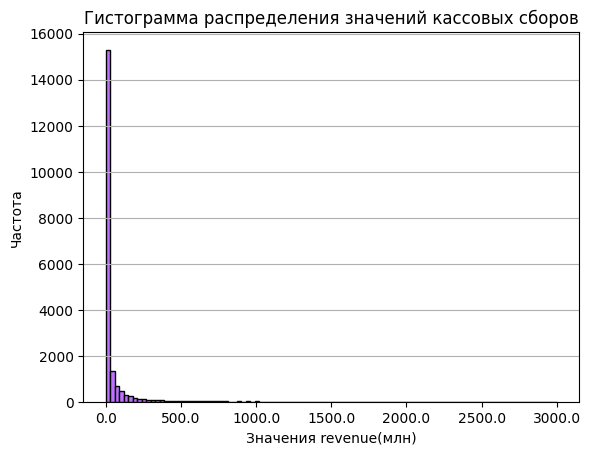

In [31]:
plt.hist(df_merged[df_merged['revenue'] > 0]['revenue'], 
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.grid(axis='y')

plt.title('Гистограмма распределения значений кассовых сборов')
plt.xlabel('Значения revenue(млн)')
plt.ylabel('Частота')

plt.show()

Большая часть данных хранит в себе значение "0" в столбце кассовых сборов (доходов). 

In [32]:
df_merged['revenue'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
revenue,989887.00,768361.36,18654928.15,-12.00,0.00,0.00,0.00,3000000000.00


Высокое значение стандартного отклонения указывает на большой разброс данных - есть выбросы. Учитывая, что 75-й квантиль равен 0, можно сделать вывод - большинство данных не имеют информации о кассовых сборах  

In [33]:
print(f'''Ненулевых значений обнаружено - {df_merged[df_merged['revenue'] > 0]['revenue'].count()}''')

Ненулевых значений обнаружено - 19358


- Объявим переменную, которая будет хранить булевую маску со значениями, где кассовые сборы были больше 0

In [34]:
filter_not_zero = df_merged['revenue'] > 0
filter_not_zero.head(3)

0    True
1    True
2    True
Name: revenue, dtype: bool

- Объявим переменные, которые будут хранить значения 30-го и 99-го квантиля

In [35]:
quantile_min = df_merged.loc[filter_not_zero, 'revenue'].quantile(0.3)
print(f'''Значение 30-го процентиля = {quantile_min.round(2)}''')

Значение 30-го процентиля = 173832.3


In [36]:
quantile_max = df_merged.loc[filter_not_zero, 'revenue'].quantile(0.99)
print(f'''Значение 99-го процентиля = {quantile_max.round(2)}''')

Значение 99-го процентиля = 627596538.51


Отфильтруем наш датасет по значениям от 30-го квантиля до 99-го, чтобы избавиться от аномальных значений 

In [37]:
df_filtered = df_merged[(df_merged['revenue'] > quantile_min) & (df_merged['revenue'] < quantile_max)]
df_filtered = df_filtered.copy()
df_filtered.head(3)

,id,title,vote_average,release_date,revenue,budget,original_language,original_title,genres,production_countries,release_month,cpi_date,cpi
7,550,fight club,8.44,1999-10-15,100853753,63000000,en,fight club,drama,united states of america,1999-10-01,1999-10-01,168.20
9,680,pulp fiction,8.49,1994-09-10,213900000,8500000,en,pulp fiction,"thriller, crime",united states of america,1994-09-01,1994-09-01,149.40
12,1726,iron man,7.64,2008-04-30,585174222,140000000,en,iron man,"action, science fiction, adventure",united states of america,2008-04-01,2008-04-01,214.82


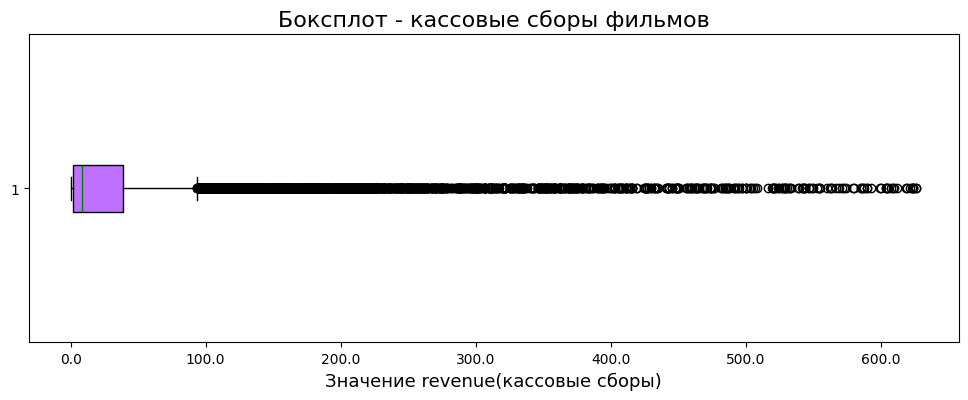

In [38]:
plt.figure(figsize=(12, 4))
plt.boxplot(df_filtered['revenue'],
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='#be71ff', color='black'),
            medianprops=dict(color='green'))

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))

plt.title('Боксплот - кассовые сборы фильмов', fontsize=16)
plt.xlabel('Значение revenue(кассовые сборы)', fontsize=13)

plt.show()

На боксплоте видно, что все аномальные значения находятся справа - их довольно много. 
Это бестселлеры, которые действительно получили огромные кассовые сборы

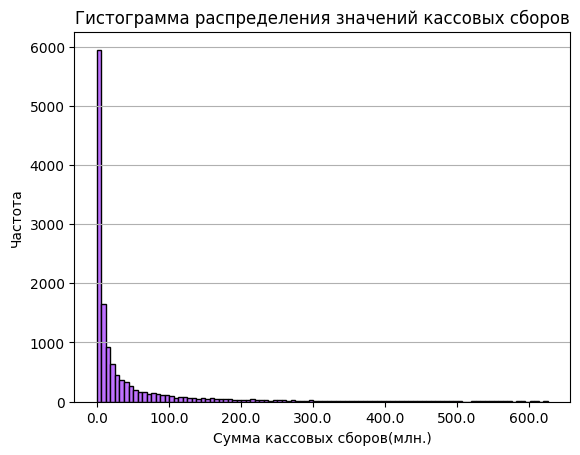

In [39]:
plt.hist(df_filtered['revenue'], 
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.grid(axis='y')

plt.title('Гистограмма распределения значений кассовых сборов')
plt.xlabel('Сумма кассовых сборов(млн.)')
plt.ylabel('Частота')

plt.show()

In [40]:
df_filtered['revenue'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
revenue,13356.00,42514372.85,84893301.83,173871.00,1800000.00,8750339.00,38530543.25,626203271.00


In [41]:
filtered_rows = df_filtered.shape[0]
print(f'''Было удалено {old_rows - filtered_rows} строк.
Мы лишились {round((old_rows - filtered_rows)
            / old_rows * 100, 2)}% данных''')

Было удалено 1222426 строк.
Мы лишились 98.92% данных


### Анализ BUDGET

In [42]:
print(f'''{df_filtered[df_filtered['budget'] == 0].shape[0]} количество фильмов не содержат информации о бюджете ''')

4355 количество фильмов не содержат информации о бюджете 


In [43]:
print(f'''{df_filtered[df_filtered['budget'] > 0].shape[0]} количество фильмов содержат информацию о бюджете''')

9001 количество фильмов содержат информацию о бюджете


In [44]:
df_filtered['budget'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
budget,13356.00,15815436.21,30148967.22,0.00,0.00,3000000.00,19000000.00,645654654.00


Мы видим большое стандратное отклонение, которое указывает на выбросы. У 25% фильмов отсутсвует информация о бюджете

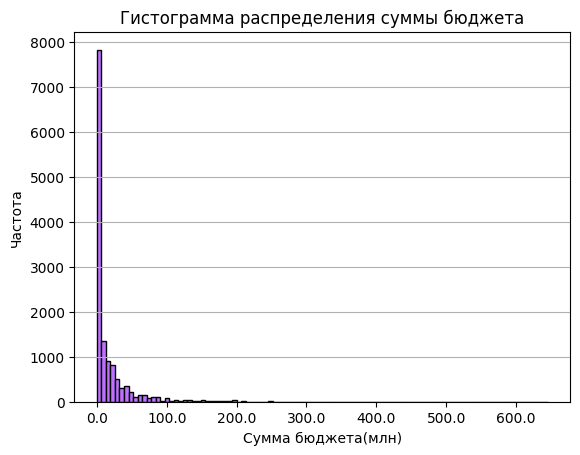

In [45]:
plt.hist(df_filtered['budget'],
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.grid(axis='y')

plt.title('Гистограмма распределения суммы бюджета')
plt.xlabel('Сумма бюджета(млн)')
plt.ylabel('Частота')


plt.show()

- Распределение сильно смещено вправо: встречаются редкие, но очень крупные бюджеты
- Около 25% фильмов имеют нулевой бюджет, это значит, что данные либо отсутствуют - это типичная ситуация для фильмов, финансируемых: государственными субсидиями, международными фондами, кинокомиссиями.

По этой причине нулевые значения мы оставляем 

### Анализ PRODUCTION_COUNTRIES

In [46]:
df_filtered['production_countries'].value_counts()

production_countries
united states of america                                                         5845
india                                                                             700
united kingdom, united states of america                                          418
japan                                                                             412
united kingdom                                                                    328
                                                                                 ... 
australia, canada, switzerland, united states of america                            1
france, united kingdom, italy                                                       1
australia, china, france, hong kong, united kingdom, united states of america       1
denmark, france, germany, japan, united kingdom, united states of america           1
kazakhstan                                                                          1
Name: count, Length: 1130, dtype:

В данных по странам производства присутствуют строки с несколькими странами. Будем брать первую страну из списка, так как чаще всего именно она отражает основную страну производства. Такой подход соответствует распространённой практике в исследовательских работах и научных публикациях, где при множественном указании стран приоритет отдаётся первой по порядку как представителю основного продюсера проекта.

In [47]:
df_filtered['main_country'] = (
                                df_filtered['production_countries']
                               .str.split(',', expand=True)[0]
                               )

In [48]:
df_filtered.head(3)

,id,title,vote_average,release_date,revenue,budget,original_language,original_title,genres,production_countries,release_month,cpi_date,cpi,main_country
7,550,fight club,8.44,1999-10-15,100853753,63000000,en,fight club,drama,united states of america,1999-10-01,1999-10-01,168.20,united states of america
9,680,pulp fiction,8.49,1994-09-10,213900000,8500000,en,pulp fiction,"thriller, crime",united states of america,1994-09-01,1994-09-01,149.40,united states of america
12,1726,iron man,7.64,2008-04-30,585174222,140000000,en,iron man,"action, science fiction, adventure",united states of america,2008-04-01,2008-04-01,214.82,united states of america


In [49]:
df_filtered['main_country'].value_counts()

main_country
united states of america    6037
united kingdom               810
india                        742
france                       706
canada                       496
                            ... 
senegal                        1
namibia                        1
macedonia                      1
bosnia and herzegovina         1
kazakhstan                     1
Name: count, Length: 109, dtype: int64

In [50]:
df_country = df_filtered['main_country'].value_counts(ascending=True).reset_index()
df_country.head(2)

,main_country,count
0,kazakhstan,1
1,lebanon,1


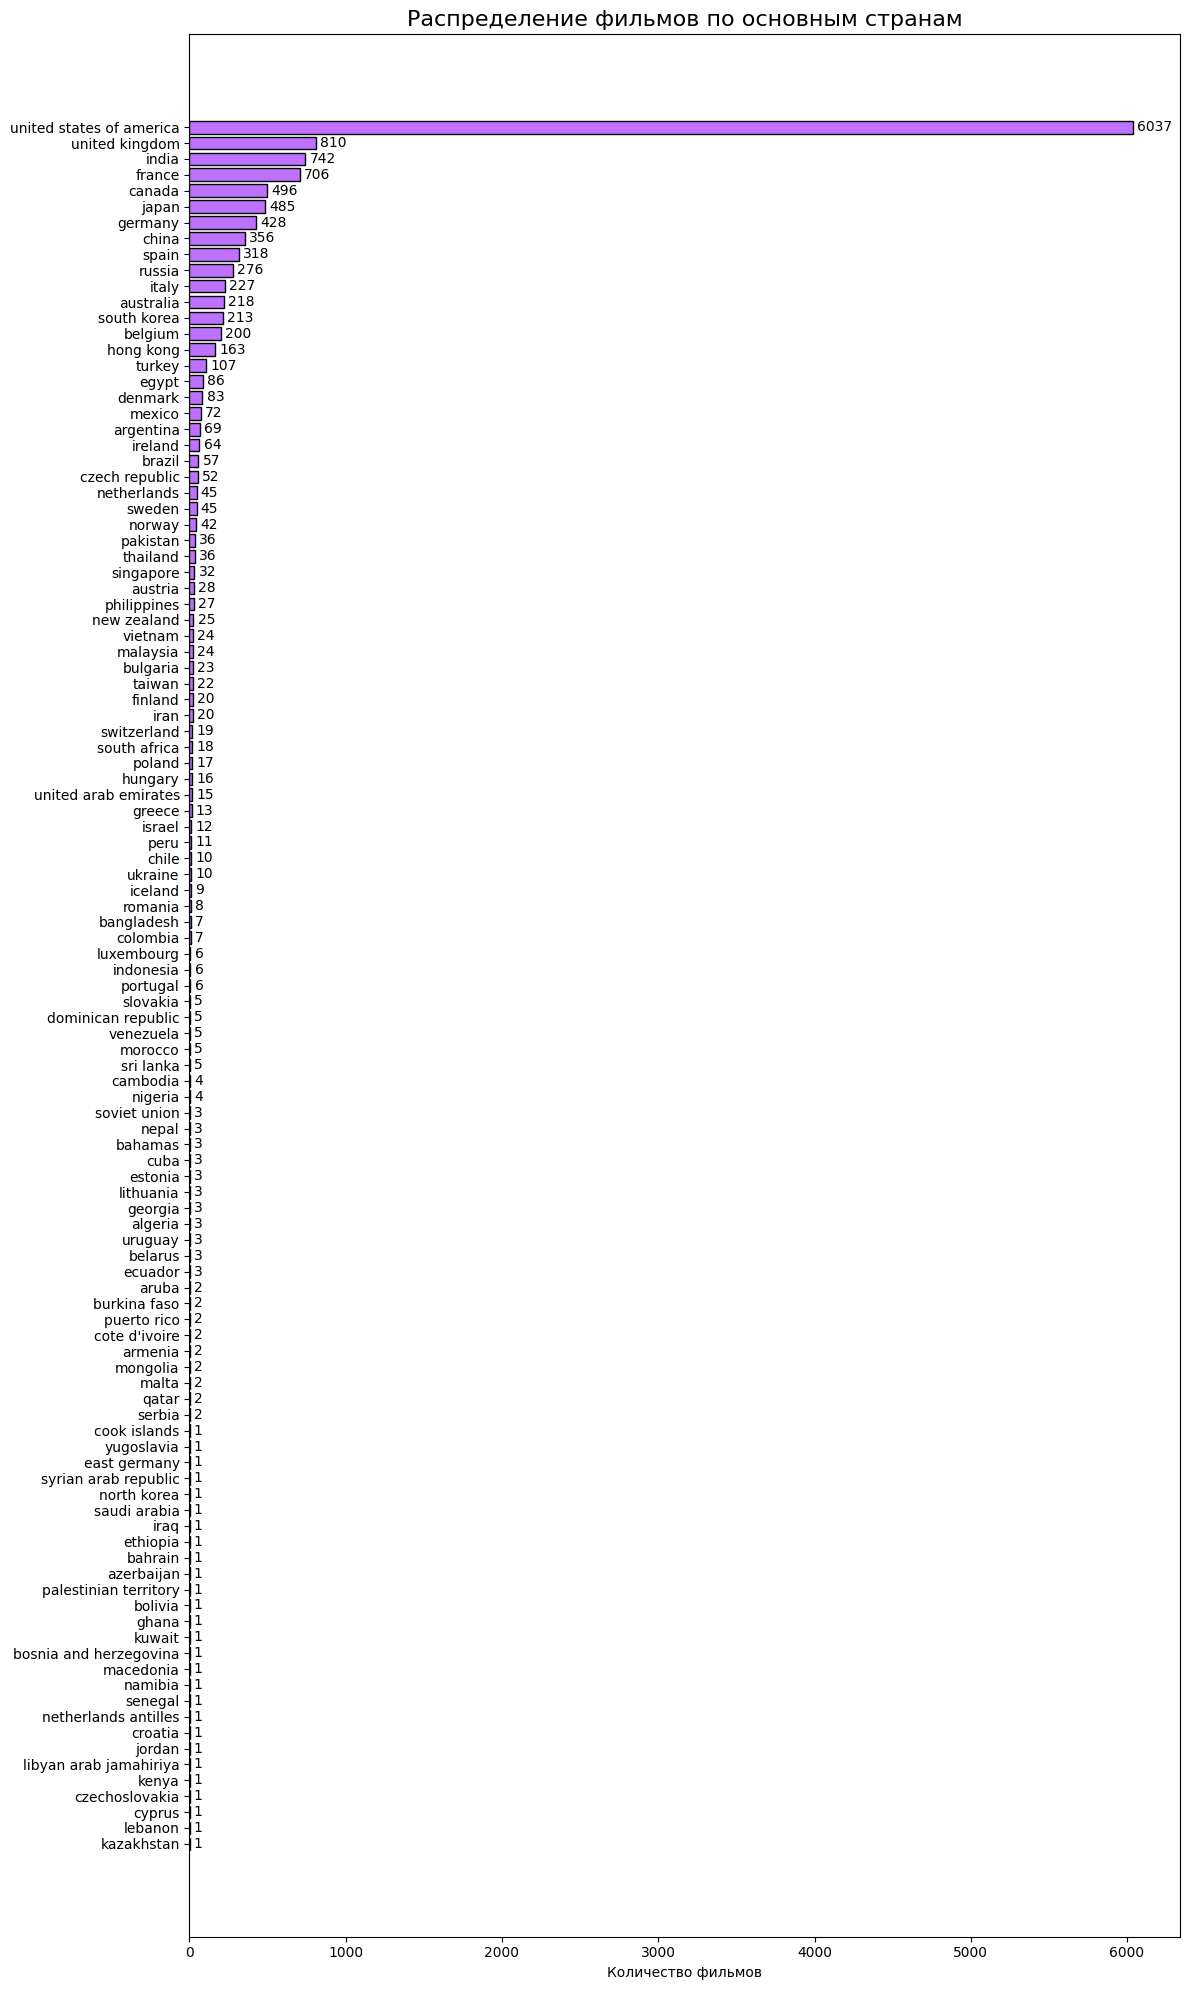

In [51]:
plt.figure(figsize=(12, 20))

bars = plt.barh(
    y=df_country['main_country'],
    width=df_country['count'],
    color='#be71ff',
    edgecolor='black'
)

plt.gca().bar_label(bars, fmt='%.0f', padding=3)

plt.xlabel('Количество фильмов')
plt.title('Распределение фильмов по основным странам', fontsize=16)
plt.tight_layout()
plt.show()

### Анализ VOTE_AVERTAGE

In [52]:
df_filtered['vote_average'].value_counts()

vote_average
0.00    376
6.00    223
7.00    149
6.50    140
6.20    129
       ... 
7.90      1
6.94      1
5.18      1
8.08      1
8.44      1
Name: count, Length: 3262, dtype: int64

У нас действительно могут встречаться фильмы без оценок пользователей, так что тут значение 0 не критично

In [53]:
df_filtered['vote_average'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
vote_average,13356.00,6.19,1.46,0.00,5.75,6.39,7.00,10.00


Стандартное отклонение не критичное, а значит вариативность умеренная

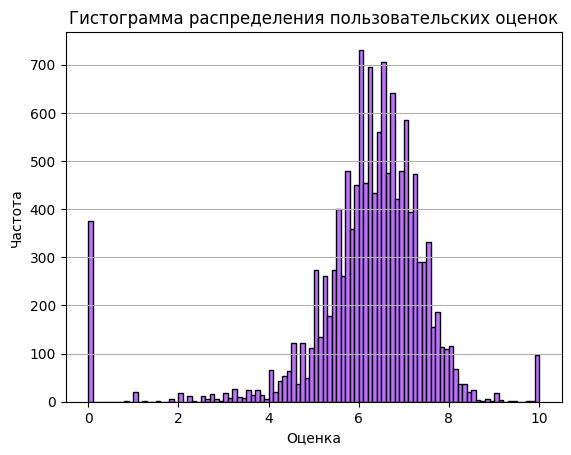

In [54]:
plt.hist(df_filtered['vote_average'], 
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.grid(axis='y')

plt.title('Гистограмма распределения пользовательских оценок')
plt.xlabel('Оценка')
plt.ylabel('Частота')

plt.show()

- Распределение с левосторонней ассиметрией
- Вытянутый левый хвост обусловлен наличием свыше 900 нулевых оценок

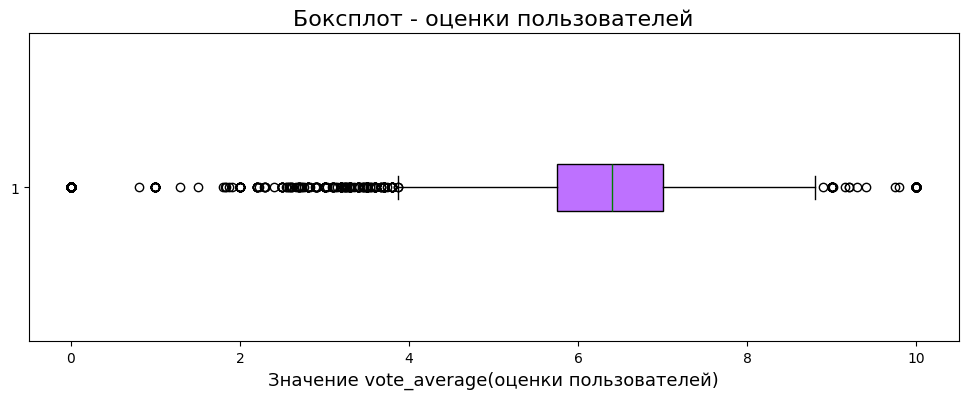

In [55]:
plt.figure(figsize=(12, 4))
plt.boxplot(df_filtered['vote_average'],
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='#be71ff', color='black'),
            medianprops=dict(color='green'))

plt.title('Боксплот - оценки пользователей', fontsize=16)
plt.xlabel('Значение vote_average(оценки пользователей)', fontsize=13)

plt.show()

- Основная часть оценок приходится на значения ~5.6-6.97. Слева у нас наблюдается много выбросов, справа выбросы тоже есть, но их меньше. 
- Низкая оценка, как и ее отсутствие, может быть связана с малой популярностью фильма, возможно даже полным отсутствием популярности. 
- Высокая оценка может быть связана с большой положительной популярностью фильма, а также присутствует и такой вариант, что фильм не особо известен, у него не так много оценок - но все высокие. Тогда наша средняя оценка сильно завышается

### Уникальные значения

- Уникальные значения в жанрах

In [56]:
df_filtered['genres'].value_counts()

genres
drama                                                            983
comedy                                                           914
drama, romance                                                   485
comedy, drama                                                    425
comedy, romance                                                  408
                                                                ... 
mystery, drama, thriller, comedy                                   1
family, comedy, adventure, animation, fantasy                      1
adventure, action, fantasy, war, history                           1
action, adventure, comedy, fantasy, science fiction, thriller      1
drama, family, documentary                                         1
Name: count, Length: 2326, dtype: int64

- У нас встречаются строки с перечислением нескольких жанров. Для нашего исследования мы оставляем их в исходном виде. При построении дашборда предполагается использовать проверку по жанрам через оператор LIKE (SQL)

In [57]:
print(f'''У {df_filtered['genres'].isnull().sum()} фильмов отсутствует информация о жанрах''')

У 90 фильмов отсутствует информация о жанрах


- Нулевые значения можно заменить на "undefined"

In [58]:
df_filtered['genres'] = df_filtered['genres'].fillna('undefined')

In [59]:
df_filtered['genres'].value_counts()

genres
drama                                                            983
comedy                                                           914
drama, romance                                                   485
comedy, drama                                                    425
comedy, romance                                                  408
                                                                ... 
mystery, drama, thriller, comedy                                   1
family, comedy, adventure, animation, fantasy                      1
adventure, action, fantasy, war, history                           1
action, adventure, comedy, fantasy, science fiction, thriller      1
drama, family, documentary                                         1
Name: count, Length: 2327, dtype: int64

Изучим уникальные данные по столбцу с original_language

In [60]:
df_tmdb['original_language'].value_counts()

original_language
en    671306
fr     72113
es     63372
de     57609
ja     54066
       ...  
ee         1
ve         1
kv         1
hz         1
ii         1
Name: count, Length: 176, dtype: int64

- Пропуски отсутствуют - данные выглядят полными

### Учет инфляции 

Добавим два столбца:
- `current_budget` - бюджет с учетом инфляции
- `current_revenue` - кассовые сборы с учетом инфляции

In [61]:
df_filtered['current_budget'] = (
    df_filtered['budget'] * (latest_cpi / df_filtered['cpi'])
)
df_filtered[['budget', 'current_budget']].head(3)

,budget,current_budget
7,63000000,120155083.23
9,8500000,18251388.89
12,140000000,209061878.85


In [62]:
df_filtered['current_revenue'] = (
    df_filtered['revenue'] * (latest_cpi / df_filtered['cpi'])
)
df_filtered[['revenue', 'current_revenue']].head(3)

,revenue,current_revenue
7,100853753,192350652.16
9,213900000,459290833.33
12,585174222,873840159.32


### Итог 

In [63]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13356 entries, 7 to 989264
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    13356 non-null  int64         
 1   title                 13356 non-null  object        
 2   vote_average          13356 non-null  float64       
 3   release_date          13356 non-null  datetime64[ns]
 4   revenue               13356 non-null  int64         
 5   budget                13356 non-null  int64         
 6   original_language     13356 non-null  object        
 7   original_title        13356 non-null  object        
 8   genres                13356 non-null  object        
 9   production_countries  13015 non-null  object        
 10  release_month         13356 non-null  datetime64[ns]
 11  cpi_date              13356 non-null  datetime64[ns]
 12  cpi                   13356 non-null  float64       
 13  main_country        

In [64]:
columns_to_keep = [
    "id",
    "title",                 
    "original_title",        
    "original_language",     
    "release_date",          
    "genres",                
    "budget",                
    "revenue",               
    "vote_average",          
    "main_country",
    "cpi", 
    "current_budget",
    "current_revenue"  
]

In [72]:
df_filtered = df_filtered[columns_to_keep].copy()
df_filtered = df_filtered.reset_index(drop=True)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13356 entries, 0 to 13355
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 13356 non-null  int64         
 1   title              13356 non-null  object        
 2   original_title     13356 non-null  object        
 3   original_language  13356 non-null  object        
 4   release_date       13356 non-null  datetime64[ns]
 5   genres             13356 non-null  object        
 6   budget             13356 non-null  int64         
 7   revenue            13356 non-null  int64         
 8   vote_average       13356 non-null  float64       
 9   main_country       13015 non-null  object        
 10  cpi                13356 non-null  float64       
 11  current_budget     13356 non-null  float64       
 12  current_revenue    13356 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(3), object(5)
memory 

In [66]:
print(f'''Наш отфильтрованный и предобработанный датасет состоит из:
- {df_filtered.shape[0]} строк
- {df_filtered.shape[1]} столбцов''')

Наш отфильтрованный и предобработанный датасет состоит из:
- 13356 строк
- 13 столбцов




- `id` - уникальный идентификатор фильма
- `title` - англоязычное название фильма
- `original_title` - оригинальное название фильма
- `original_language` - язык оригинала
- `release_date` - дата выхода фильма
- `genres` - жанры фильма
- `budget` - бюджет фильма (в долларах)
- `revenue` - кассовые сборы, доход (в долларах)
- `vote_average` - рейтинг фильма, основанный на пользовательских голосах
- `main_country` - главная страна, учавствовавшая в производстве фильма
- `cpi` - cpi на дату выхода фильма
- `latest_cpi` - актуальный cpi
- `current_budget` - сумма бюджета с учетом инфляции
- `current_revenue` - сумма кассовых сборов с учетом инфляции

 ## Графики (примеры + могут дополняться)

**scatter plot - corrent_revenue vs vote_average**


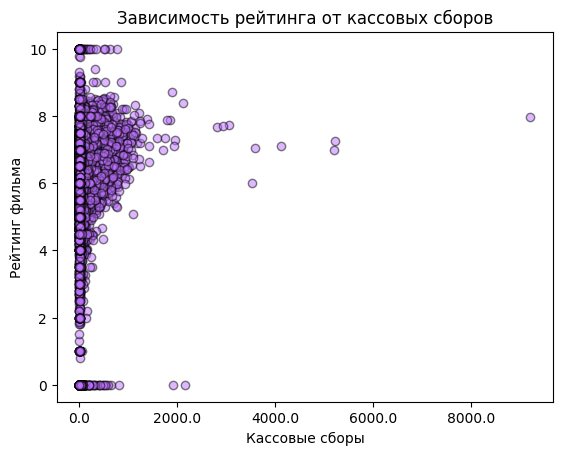

In [67]:
plt.scatter(
    df_filtered['current_revenue'],
    df_filtered['vote_average'],
    alpha=0.5,
    color='#be71ff',
    edgecolors='black'
)
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.title('Зависимость рейтинга от кассовых сборов')
plt.xlabel('Кассовые сборы')
plt.ylabel('Рейтинг фильма')
plt.show()

- Уберем выбросы

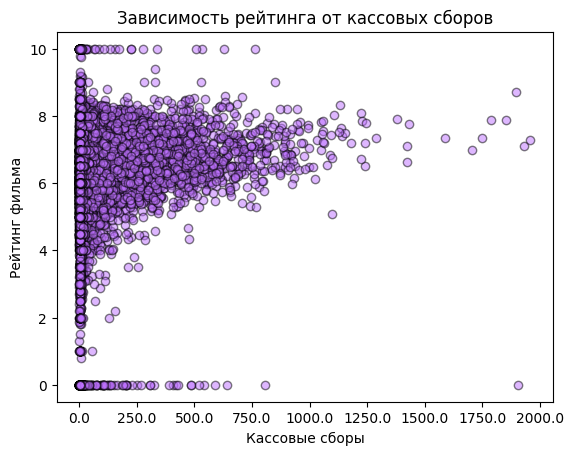

In [68]:
plt.scatter(
    df_filtered[df_filtered['current_revenue'] < 2000000000]['current_revenue'],
    df_filtered[df_filtered['current_revenue'] < 2000000000]['vote_average'],
    alpha=0.5,
    color='#be71ff',
    edgecolors='black'
)
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.title('Зависимость рейтинга от кассовых сборов')
plt.xlabel('Кассовые сборы')
plt.ylabel('Рейтинг фильма')
plt.show()

- Большинство фильмов имеют относительно низкие сборы, вне зависимости от рейтинга.
- Высокие сборы - чаще высокие рейтинги. На графике видно, что с увеличением значения кассовых сборов, фильмов становится меньше, однако рейтинг у них держится в районе 6-9.

**Линейный график - кол-во фильмов**

In [69]:
df_filtered['year'] = pd.to_datetime(df_filtered['release_date']).dt.year

In [70]:
films_year = df_filtered['year'].value_counts()
films_year = films_year.reset_index(drop=False)
films_year = films_year.sort_values(by='year')
films_year.head()

,year,count
108,1913,1
106,1914,2
111,1915,1
102,1916,3
105,1918,2


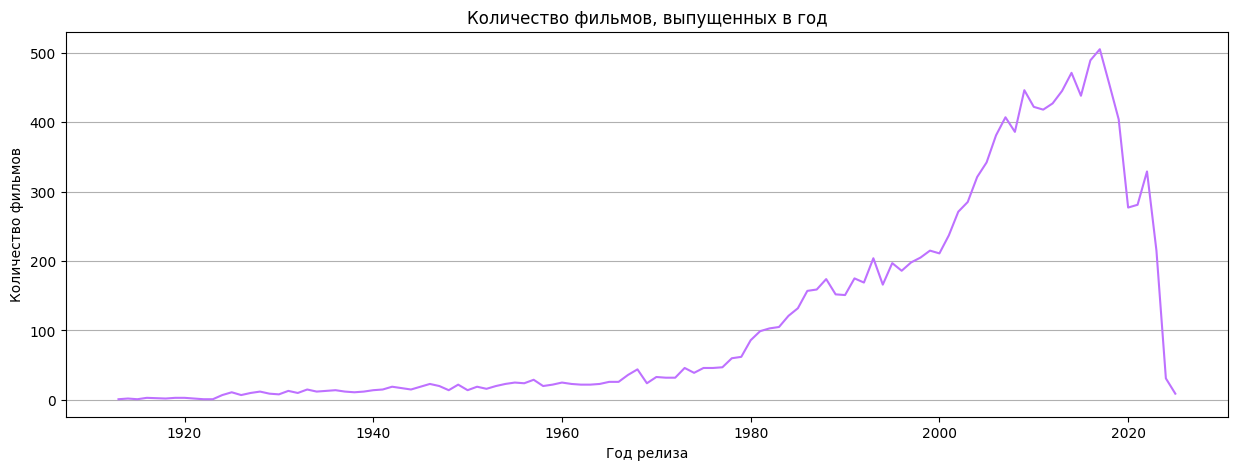

In [71]:
plt.figure(figsize=(15, 5))

plt.plot(films_year['year'],
         films_year['count'],
          color='#be71ff')

plt.title('Количество фильмов, выпущенных в год')
plt.xlabel('Год релиза')
plt.ylabel('Количество фильмов')
plt.grid(axis='y')
plt.show()

продолжение следует...